In [1]:
import tensorflow as tf
from scipy.stats import norm
import numpy as np
import pandas as pd

Black-Scholes data generation

In [2]:
S = np.linspace(50, 650, 600*4 + 1)
K = np.linspace(25, 750, 725*4 + 1)
dt = np.arange(1, 365 + 1) / 365
sigma = np.linspace(5, 90, 85 * 100 + 1) / 100
r = np.linspace(1, 5, 401) / 100

In [3]:
def gen_data(n=10**6, seed=0):
    np.random.seed(seed=seed)
    df = np.zeros(shape=(n, 6))

    df[:, 0] = np.random.choice(S, size=n)
    df[:, 1] = np.floor(np.random.uniform(0.65 * df[:, 0], 1.35 * df[:, 0], size=n))
    df[:, 2] = np.random.choice(dt, size=n)
    df[:, 3] = np.random.choice(sigma, size=n)
    df[:, 4] = np.random.choice(r, size=n)

    Phi = norm.cdf
    d_1 = (np.log(df[:, 0] / df[:, 1]) + (df[:, 4] + df[:, 3] ** 2 / 2) * df[:, 2]) / (df[:, 3] * np.sqrt(df[:, 2]))
    d_2 = d_1 - df[:, 3] * np.sqrt(df[:, 2])

    df[:, 5] = df[:, 0] * Phi(d_1) - df[:, 1] * np.exp(-df[:, 4] * df[:, 2]) * Phi(d_2)
    return df

In [4]:
train_df, test_df = gen_data(2 * 10**5), gen_data(10**5, seed=1)

train_X, train_y = train_df[:, :-1], train_df[:, -1]
test_X, test_y = test_df[:, :-1], test_df[:, -1]

Tensorflow NN

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(5,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1,
                        activation='relu',
                        )
])

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError()]
              )
model.fit(train_X, train_y, batch_size=2**6, epochs=10)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1030.8007 - mean_absolute_error: 22.9455
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 385.9427 - mean_absolute_error: 13.4586
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 207.6504 - mean_absolute_error: 9.8355
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 177.7746 - mean_absolute_error: 9.0504
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 163.5047 - mean_absolute_error: 8.5472
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 145.9191 - mean_absolute_error: 8.0670
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 134.5436 - mean_absolute_error: 7.8154
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 133.6462 - mean_absolute_error: 7.7872
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 122.9634 - mean_absolute_error: 7.4832
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 121.4616 - mean_absolut

In [7]:
trained_model = tf.keras.models.load_model('bs_nn.keras')

In [8]:
output_df = pd.DataFrame(test_X, columns=["S", "K", "dt", "sigma", "r"])
output_df["price"] = test_y
output_df["model_price"] = trained_model.predict(test_X)
output_df["residual"] = test_y - output_df["model_price"]
output_df["relative_error"] = output_df["residual"] / output_df["price"]
output_df["abs_relative_error"] = np.abs(output_df["residual"] / output_df["price"])
output_df

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


,S,K,dt,sigma,r,price,model_price,residual,relative_error,abs_relative_error
0,315.25,278.0,0.947945,0.6804,0.0474,102.521339,102.242783,0.278557,0.002717,0.002717
1,108.75,117.0,0.920548,0.0593,0.0279,0.717128,0.679514,0.037614,0.052451,0.052451
2,324.00,349.0,0.791781,0.3947,0.0145,36.857884,36.489441,0.368443,0.009996,0.009996
3,276.25,276.0,0.493151,0.8894,0.0408,69.936793,69.892929,0.043864,0.000627,0.000627
4,290.00,200.0,0.742466,0.7215,0.0360,117.977727,117.652054,0.325673,0.002760,0.002760
...,...,...,...,...,...,...,...,...,...,...
99995,616.25,541.0,0.071233,0.7330,0.0418,93.456608,99.166702,-5.710095,-0.061099,0.061099
99996,114.00,127.0,1.000000,0.4379,0.0437,16.844611,17.186378,-0.341768,-0.020289,0.020289
99997,53.00,62.0,0.986301,0.3764,0.0309,5.286297,5.665598,-0.379301,-0.071752,0.071752
99998,428.00,515.0,0.731507,0.3578,0.0200,25.630359,24.694263,0.936096,0.036523,0.036523


Plots

In [9]:
import matplotlib.pyplot as plt

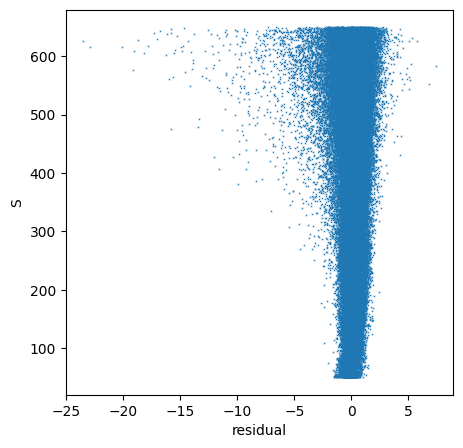

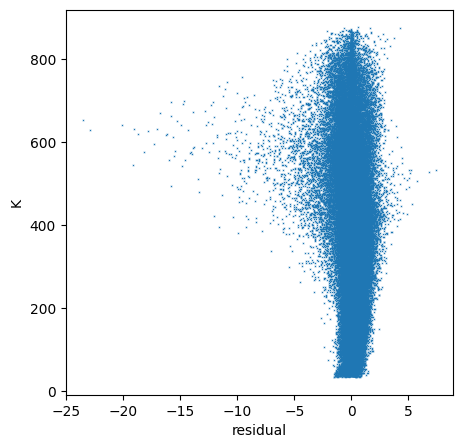

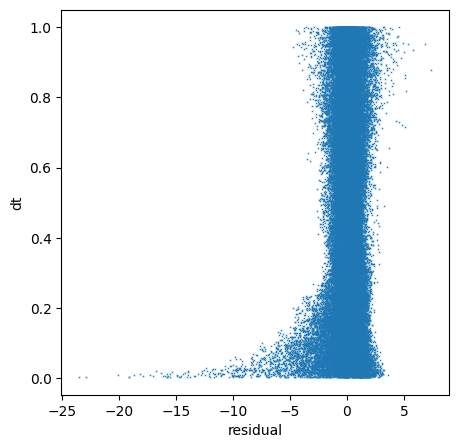

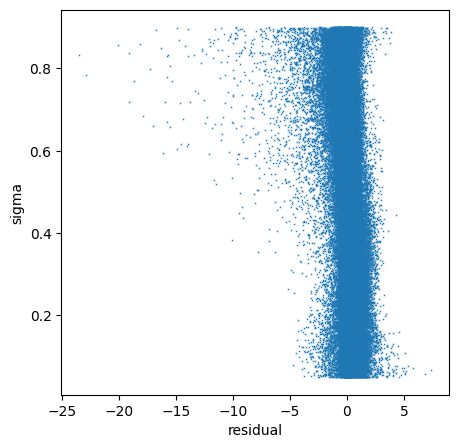

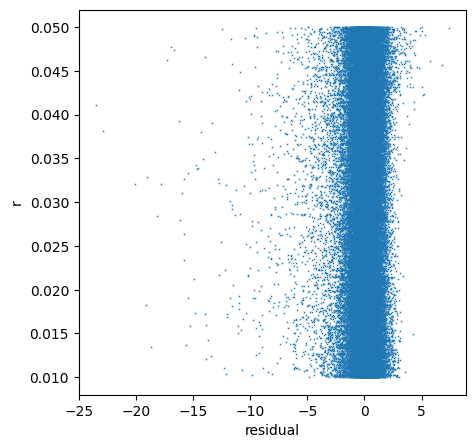

In [10]:
for col in ["S", "K", "dt", "sigma", "r"]:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(output_df["residual"], output_df[col], s=0.1, marker="x")
    ax.set_xlabel("residual")
    ax.set_ylabel(col)
    plt.show()

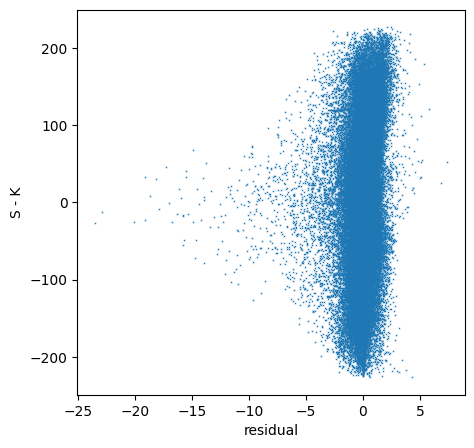

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(output_df["residual"], output_df["S"] - output_df["K"], s=0.1, marker="x")
ax.set_xlabel("residual")
ax.set_ylabel("S - K")
plt.show()